In [1]:
import os
from pathlib import Path
import re
from matplotlib import pyplot as plt  
import json
import numpy as np
import networkx as nx
import re

[(3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (7, 2), (8, 2), (8, 3), (8, 4), (18, 4), (18, 3), (18, 2)]
100


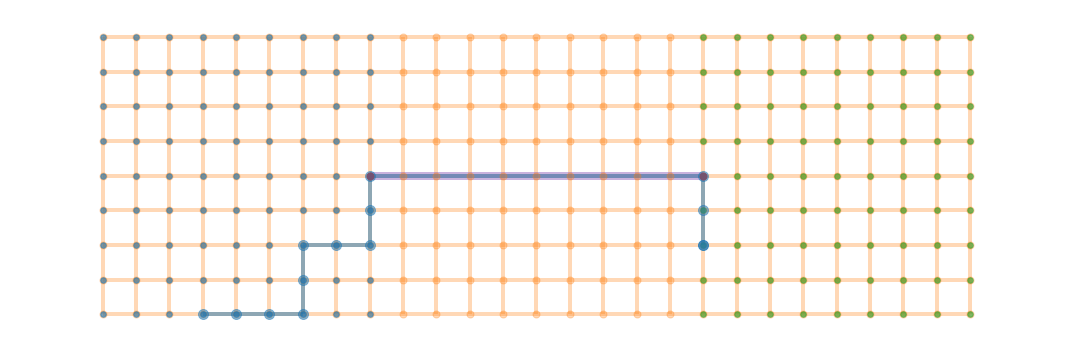

In [79]:
# 这个部门模拟在两个城市中有一条高速公路的场景，A城市想要到 B城市去则必然经过高速公路，
# 在这样的setting下，高速公路一定会成为dictionary中最为重要的一个元素
plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.margins(0.11)
matrix_size = 9
G = nx.grid_2d_graph(matrix_size*3, matrix_size)
pos = dict( (n, n) for n in G.nodes() )
nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.3, node_color="tab:orange")
nx.draw_networkx_edges(G, pos, alpha=0.3, width=4, edge_color="tab:orange")

startpoint_of_highspeedway=(matrix_size-1,matrix_size//2)
endpoint_of_highspeedway=(matrix_size*2,matrix_size//2)
for i in range(matrix_size):
    for j in range(matrix_size):
        nx.draw_networkx_nodes(G, pos, node_size=30, alpha=0.6, nodelist=[(i,j)], node_color="tab:blue")
        nx.draw_networkx_nodes(G, pos, node_size=30, alpha=0.6, nodelist=[(i+matrix_size*2,j)], node_color="tab:green")
nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.9, nodelist=[startpoint_of_highspeedway], node_color="tab:red")
nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.9, nodelist=[endpoint_of_highspeedway], node_color="tab:red")
nx.draw_networkx_edges(G, pos, alpha=0.5, width=8, edgelist=[(startpoint_of_highspeedway,endpoint_of_highspeedway)],edge_color="tab:purple")

generated_trajectory_dataset_highspeedway=[]
np.random.seed(42)
for cnt in range(100):
    random_pos = np.random.randint(0, matrix_size-1, size=4)
    start_point = (random_pos[0], random_pos[1])
    end_point = (random_pos[2]+matrix_size*2, random_pos[3])
    initial_graph_weight = np.random.randint(3,10,size=(matrix_size*(3*matrix_size-1)+3*matrix_size*(matrix_size-1)))
    cnt = 0
    for edge in G.edges():
        G.edges[edge[0],edge[1]]["weight"] = initial_graph_weight[cnt]
        cnt += 1

    tra = nx.shortest_path(G, source=start_point, target=startpoint_of_highspeedway, weight="weight")
#     for i in range(len(tra)-1):
#         nx.draw_networkx_edges(G, pos, alpha=0.5, width=4, edgelist=[(tra[i],tra[i+1])],edge_color="tab:blue")
#         nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.5, nodelist=[tra[i]], node_color="tab:blue")
#     nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.8, nodelist=[tra[-1]], node_color="tab:blue")  

    trajectory=tra
    # print(trajectory)
    tra = nx.shortest_path(G, source=endpoint_of_highspeedway, target=end_point, weight="weight")
#     for i in range(len(tra)-1):
#         nx.draw_networkx_edges(G, pos, alpha=0.5, width=4, edgelist=[(tra[i],tra[i+1])],edge_color="tab:blue")
#         nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.5, nodelist=[tra[i]], node_color="tab:blue")
#     nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.8, nodelist=[tra[-1]], node_color="tab:blue")
    trajectory=trajectory+tra
    generated_trajectory_dataset_highspeedway.append(trajectory)
# print(tra)
print(trajectory)
print(len(generated_trajectory_dataset_highspeedway))

tra=trajectory
for i in range(len(tra)-1):
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=4, edgelist=[(tra[i],tra[i+1])],edge_color="tab:blue")
    nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.5, nodelist=[tra[i]], node_color="tab:blue")
nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.8, nodelist=[tra[-1]], node_color="tab:blue")

plt.tight_layout()
plt.axis("off")
plt.show()

In [96]:
path_num = len(generated_trajectory_dataset_highspeedway)
num_point= 3 * matrix_size**2  # the number of vertics
length = matrix_size * 3  # the length of the grid
T_value = -np.ones((num_point, num_point))  # T_value stores an adaption of the number (num) of trajactoy that contain the path (s,t), which is pre-computed ly lb + 1/num
norm_of_opt_value = 0
opt_div_value = -np.ones((num_point, num_point))  # store the optimal T_value of all the trajectory
# opt_div_value_old = np.zeros((num_point, num_point))
opt_div_res  = []  # the optimal division of all the trajectory
for i in range(num_point):  # maybe can convert to a list/dict to save some space
    opt_div_res.append([])
    for j in range(num_point):
        opt_div_res[i].append([])
la = 0.010  # lambda which impact the number of division for each trajectory
epsilon = 1e-3

trajectory_each_epoch = generated_trajectory_dataset_highspeedway[:]  # store the trajectory set of each iterations  this can of duplication can make sure these two edition is point to one area in main memery
trajectory_each_epoch_adaption = generated_trajectory_dataset_highspeedway[:]  # store the adaptedd trajectory set of each iterations

# compute all T_value from all trajactory in each iterations
def get_t(path):
    res = 0
    for tra in trajectory_each_epoch:
        if str(path)[1:-1] in str([i[0]+i[1]*length for i in tra]):
            res += 1
    if res == 0:
        res = 1
    return res

def Generate_Pathlet(path, depth):  # s is the source and t is the target
    # why here needs global variables?
    global opt_div_value
    global opt_div_res
    candidate = {}   # record all the candidate T_value

    # tmp represents the situation without any division
    # still need to consider the uncutted version of (s, v)
    # print(path, path[0], path[-1], T_value[path[0], path[-1]])
    if T_value[path[0], path[-1]] != -1:
        tmp = la + 1/T_value[path[0], path[-1]]
        return (tmp, opt_div_res[path[0]][path[-1]])
    else:
        tmp = la + 1/get_t(path)
        T_value[path[0], path[-1]] = get_t(path)

    candidate[path[0]] = tmp

    # enforce our Alg. must divide the trajectory into pieces rather than just return itself
    # if depth == 1:
    #     candidate[path[0]] = 100
    
    # stop condition 
    if len(path) == 2:
        opt_div_value[path[0], path[-1]] = tmp
        opt_div_res[path[0]][path[-1]] = [(path[0]%length, path[0]//length), (path[-1]%length, path[-1]//length)]
        return [tmp, [(path[0]%length, path[0]//length), (path[-1]%length, path[-1]//length)]]

    i = 1
    for v in path[1:-1]:      
        # judge if the optimal value has been computed and stored previously
        left = Generate_Pathlet(path[:i+1], depth+1)
        right = Generate_Pathlet(path[i:], depth+1)
        candidate[v] = left[0] + right[0]
        i += 1

    # what if a trajectory onl have one edge, the code won't come to this line and it is a fallcy
    v_opt = min(candidate.keys(), key=(lambda k: candidate[k]))
    key_opt = path.index(v_opt)
    opt_div_value[path[0], path[-1]] = candidate[v_opt]
    if(key_opt == 0 or key_opt == -1 or key_opt == len(path)-1):
        segments = [(x%length, x//length) for x in path]
    else:
        segments = []
        segments.append(opt_div_res[path[0]][v_opt])
        segments.append(opt_div_res[v_opt][path[-1]])
    opt_div_res[path[0]][path[-1]] = segments
    
    return [candidate[v_opt], segments]

while np.abs(np.linalg.norm(opt_div_value) - norm_of_opt_value)/num_point >= epsilon:   # matrix norm smaller than 1e-6 and the optimal value od (s,t) may recprd the last poeeible trajectory in dataset of there exist some trajectories sharing the same sorece and target!!
    print("the value in this eopch is {}".format(np.abs(np.linalg.norm(opt_div_value) - norm_of_opt_value)/num_point))
    print(np.linalg.norm(opt_div_value), norm_of_opt_value)
    trajectory_each_epoch = trajectory_each_epoch_adaption[:]
    trajectory_each_epoch_adaption = generated_trajectory_dataset_highspeedway[:]
    norm_of_opt_value = np.linalg.norm(opt_div_value)
    for i in range(path_num):
        T_value = -np.ones((num_point, num_point))
        # change the coordinate into sequence number
        target = generated_trajectory_dataset_highspeedway[i]
        path = [i[0]+i[1]*length for i in target]
        # print("path:{0}, target:{1}".format(path, target))
        result = Generate_Pathlet(path, 0)
        # update all the trajectory into two parts according to the regression result
        str_result = str(result[1])
        revise = re.sub('\[+', '[', str_result)
        revise = re.sub(r']+', ']', revise)
        change = list(eval(revise))
        if isinstance(change[0], list):
            for j in range(len(change)):
                if change[j] not in trajectory_each_epoch_adaption:
                    trajectory_each_epoch_adaption.append(change[j])
            trajectory_each_epoch_adaption.remove(target)
        # acc = 0
        # for k in trajectory_each_epoch_adaption:
        #     if k in generated_trajectory_dataset_highspeedway:
        #         acc += 1
        # print(len(trajectory_each_epoch_adaption), acc)

the value in this eopch is 1.0
243.0 0
the value in this eopch is 0.011061434904814954
240.31207131812997 243.0


In [94]:
acc = 0
print(len(generated_trajectory_dataset_highspeedway))
for i in trajectory_each_epoch_adaption:
    if i in generated_trajectory_dataset_highspeedway:
        acc += 1
    print(i, '\r')
print(len(trajectory_each_epoch_adaption), acc)

100
[(0, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4), (18, 4), (19, 4), (20, 4), (20, 5), (20, 6), (20, 7), (21, 7), (22, 7), (23, 7)] 
[(2, 0), (2, 1), (3, 1), (3, 2), (3, 3), (4, 3), (5, 3), (5, 4), (6, 4), (7, 4), (8, 4), (18, 4), (18, 3), (18, 2), (19, 2), (20, 2), (20, 1), (21, 1), (22, 1), (22, 0)] 
[(1, 1), (2, 1), (3, 1), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (7, 3), (7, 4), (8, 4), (18, 4), (19, 4), (20, 4), (21, 4), (21, 3), (22, 3), (22, 2), (22, 1), (23, 1), (24, 1)] 
[(3, 2), (4, 2), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4), (18, 4), (18, 5), (18, 6), (19, 6), (20, 6), (21, 6)] 
[(0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (6, 6), (6, 5), (6, 4), (7, 4), (8, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (22, 5), (23, 5), (23, 6), (24, 6), (25, 6)] 
[(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (7, 4), (8, 4), (18, 4), (18, 5), (18, 6), (19, 6), (20, 6), (21, 6), (22, 6), (23, 6), (24, 6)] 
[(0, 2), (1, 2), (1, 3), (2

In [77]:
for i in generated_trajectory_dataset_highspeedway:
    print(i, '\r')

[(6, 3), (7, 3), (7, 4), (8, 4), (18, 4), (19, 4), (19, 5), (19, 6), (20, 6), (21, 6), (22, 6)] 
[(0, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4), (18, 4), (19, 4), (20, 4), (20, 5), (20, 6), (20, 7), (21, 7), (22, 7), (23, 7)] 
[(2, 0), (2, 1), (3, 1), (3, 2), (3, 3), (4, 3), (5, 3), (5, 4), (6, 4), (7, 4), (8, 4), (18, 4), (18, 3), (18, 2), (19, 2), (20, 2), (20, 1), (21, 1), (22, 1), (22, 0)] 
[(3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (18, 4), (19, 4), (19, 3), (19, 2)] 
[(3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (18, 4), (19, 4), (19, 3), (19, 2)] 
[(1, 1), (2, 1), (3, 1), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (7, 3), (7, 4), (8, 4), (18, 4), (19, 4), (20, 4), (21, 4), (21, 3), (22, 3), (22, 2), (22, 1), (23, 1), (24, 1)] 
[(6, 5), (6, 4), (7, 4), (8, 4), (18, 4), (18, 3)] 
[(3, 2), (4, 2), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4), (18, 4), (18, 5), (18, 6), (19, 6), (20, 6), (21, 6)] 
[(0, 7), (1, 7), (2, 7), (3, 7), (4, 

In [28]:
import re
result = "[[(3, 2), (4, 2)], [[(4, 2), (4, 3)], [[[(4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)], [(8, 4), (18, 4), (18, 5), (18, 6), (19, 6)]], [(19, 6), (20, 6), (21, 6)]]]]"
revise = re.sub('\[+', '[', result)
revise = re.sub(r']+', ']', revise)
print('[' + revise + ']')

[[(3, 2), (4, 2)], [(4, 2), (4, 3)], [(4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)], [(8, 4), (18, 4), (18, 5), (18, 6), (19, 6)], [(19, 6), (20, 6), (21, 6)]]


In [29]:
result = revise 
# result = result.split('], [')
# list(result)
# [i.strip('[').split(',') for i in result]
str(list(eval(result)))

'[[(3, 2), (4, 2)], [(4, 2), (4, 3)], [(4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)], [(8, 4), (18, 4), (18, 5), (18, 6), (19, 6)], [(19, 6), (20, 6), (21, 6)]]'

In [ ]:
a = [2, 3]
print([a, [3, 5]] )

In [ ]:
1/get_t(([116,126]))

In [ ]:
num_point = 3 * matrix_size**2  # the number of vertics
length = matrix_size * 3  # the length of the grid
T_value = -np.ones((num_point, num_point))  # T_value stores an adaption of the number (num) of trajactoy that contain the path (s,t), which is pre-computed ly lb + 1/num
# opt_div_value = -np.ones((num_point, num_point))  # store the optimal T_value of all the trajectory
opt_div_res  = []  # the optimal division of all the trajectory
for i in range(num_point):  # maybe can convert to a list/dict to save some space
    opt_div_res.append([])
    for j in range(num_point):
        opt_div_res[i].append([])
# ver_x = np.zeros((num_point, num_point))  # symmetric for (s, t) is equivilent to (t, s), stored the division of each edge
# ver_y = np.zeros((num_point, num_point))
la = 0.010  # lambda which impact the number of division for each trajectory
trajectory_each_epoch = generated_trajectory_dataset_highspeedway  # store the trajectory set of each iterations
trajectory_each_epoch_adaption = generated_trajectory_dataset_highspeedway  # store the adaptedd trajectory set of each iterations

# compute all T_value from all trajactory in each iterations
def get_t(path):
    res = 0
    for tra in trajectory_each_epoch:
        if str(path)[1:-1] in str([i[0]+i[1]*length for i in tra]):
            res += 1
    return res

def Generate_Pathlet(path, depth):  # s is the source and t is the target
    # why here needs global variables?
    # global opt_div_value
    global opt_div_res
    candidate = {}   # record all the candidate T_value
    candidate_res = {}   # record the candidate division

    # tmp represents the situation without any division
    # still need to consider the uncutted version of (s, v)
    if T_value[path[0], path[-1]] != -1:
        tmp = la + 1/T_value[path[0], path[-1]]
        return [tmp, opt_div_res[path[0]][path[-1]]]
    else:
        tmp = la + 1/get_t(path)
        T_value[path[0], path[-1]] = get_t(path)

    candidate[path[0]] = tmp
    # candidate_res[path[0]] = [(path[0], path[-1])]

    # enforce our Alg. must divide the trajectory into pieces rather than just return itself
    # if depth == 1:
    #     candidate[path[0]] = 100
    
    # stop condition 
    if len(path) == 2:
        # opt_div_value[path[0], path[-1]] = tmp
        # ver_x[path[0], path[-1]] = -1
        # ver_y[path[0], path[-1]] = -1
        opt_div_res[path[0]][path[-1]] = [(path[0]%length, path[0]//length), (path[-1]%length, path[-1]//length)]
        return [tmp, [(path[0]%length, path[0]//length), (path[-1]%length, path[-1]//length)]]

    i = 1
    for v in path[1:-1]:      
        # judge if the optimal value has been computed and stored previously
        left = Generate_Pathlet(path[:i+1], depth+1)
        right = Generate_Pathlet(path[i:], depth+1)
        # print(path, path[:i+1], path[i:], v)
        candidate[v] = left[0] + right[0]
        i += 1

    # what if a trajectory onl have one edge, the code won't come to this line and it is a fallcy
    v_opt = min(candidate.keys(), key=(lambda k: candidate[k]))
    key_opt = path.index(v_opt)   # find the index of the optimal division in current trajectory

    # print(" " , v_opt, candidate.values())
    # key_opt = list(candidate.values()).index(v_opt)
    # print(key_opt)
    # key_opt = candidate.keys()[key_opt]
    # print(key_opt)
    # print(path, candidate, v_opt, key_opt) 
    # ver_x[path[0], path[-1]] = v_opt%length
    # ver_y[path[0], path[-1]] = v_opt//length
    # opt_div_value[path[0], path[-1]] = candidate[v_opt]

    if(key_opt == 0 or key_opt == -1 or key_opt == len(path)-1):
        segments = [(x%length, x//length) for x in path]
    else:
        # segments = [[(x%length, x//length) for x in path[:key_opt+1]], [(x%length, x//length) for x in path[key_opt:]]]
        segments = []
        # for i in range(len(opt_div_res[path[0]][v_opt])):
        #     segments.append(opt_div_res[path[0]][v_opt][i])
        # for i in range(len(opt_div_res[v_opt][path[-1]])):
        #     segments.append(opt_div_res[v_opt][path[-1]][i])
        segments.append(opt_div_res[path[0]][v_opt])
        segments.append(opt_div_res[v_opt][path[-1]])
    opt_div_res[path[0]][path[-1]] = segments
    # print(segments)
    
    return [candidate[v_opt], segments]

# change the coordinate into sequence number
index = 7
target = generated_trajectory_dataset_highspeedway[index]
print(target)
path = [i[0]+i[1]*length for i in generated_trajectory_dataset_highspeedway[index]]
print(path)
result = Generate_Pathlet(path[:], 0)
print(result)
# update all the trajectory into two parts according to the regression result
# trajectory_each_epoch_adaption.append(result[2])
# trajectory_each_epoch_adaption.remove(target)
# print(path)

## a=[0,1,2]
print(a[:1+1])
print(a[1:])

In [ ]:
num_point= 3 * matrix_size**2  # the number of vertics
length = matrix_size * 3  # the length of the grid
T_value = -np.ones((num_point, num_point))  # T_value stores an adaption of the number (num) of trajactoy that contain the path (s,t), which is pre-computed ly lb + 1/num
opt_div_value = -np.ones((num_point, num_point))  # store the optimal T_value of all the trajectory
ver_x = np.zeros((num_point, num_point))  # symmetric for (s, t) is equivilent to (t, s), stored the division of each edge
ver_y = np.zeros((num_point, num_point))
la = 1.00  # lambda which impact the number of division for each trajectory
trajectory_each_epoch = generated_trajectory_dataset_highspeedway  # store the trajectory set of each iterations

# compute all T_value from all trajactory in each iterations
def get_t(path):
    res = 0
    for tra in trajectory_each_epoch:
        if str(path)[1:-1] in str([i[0]+i[1]*length for i in tra]):
            res += 1
    return res

def Generate_Pathlet(path, depth):  # s is the source and t is the target
    # why here needs global variables?
    global opt_div_value
    # import pdb; pdb.set_trace()
    # should init T_value at every iteration
    # T_value = -np.ones((num_point, num_point))
    candidate = {}   # record all the candidate T_value
    candidate_res = {}   # record the candidate division

    # tmp represents the situation without any division
    # still need to consider the uncutted version of (s, v)
    if T_value[path[0], path[-1]] != -1:
        tmp = la + 1/T_value[path[0], path[-1]]
    else:
        T_value[path[0], path[-1]] = get_t(path)
        tmp = la + 1/T_value[path[0], path[-1]]  

    candidate[path[0]] = tmp
    candidate_res[path[0]] = [(path[0], path[-1])]

    # enforce our Alg. must divide the trajectory into pieces rather than just return itself
    # if depth == 1:
    #     candidate[path[0]] = 100
    
    # stop condition 
    if len(path) == 2:
        opt_div_value[path[0], path[-1]] = tmp
        ver_x[path[0], path[-1]] = -1
        ver_y[path[0], path[-1]] = -1
        return (tmp, (-1,-1), [])

    i = 1
    for v in path[1:-1]:      
        # judge if the optimal value has been computed and stored previously
        candidate[v] = Generate_Pathlet(path[:i+1], depth+1)[0] + Generate_Pathlet(path[i:], depth+1)[0]
        i += 1

    # what if a trajectory onl have one edge, the code won't come to this line and it is a fallcy
    v_opt = min(candidate.keys(), key=(lambda k: candidate[k]))
    ver_x[path[0], path[-1]] = v_opt%length
    ver_y[path[0], path[-1]] = v_opt//length
    opt_div_value[path[0], path[-1]] = candidate[v_opt]
    # print((candidate[v_opt], (v_opt//length, v_opt%length)))
    
    return [candidate[v_opt], (v_opt%length, v_opt//length)]

# change the coordinate into sequence number
target = generated_trajectory_dataset_highspeedway[1]
print(target)
path = [i[0]+i[1]*length for i in generated_trajectory_dataset_highspeedway[1]]
result = Generate_Pathlet(path[:], 0)
# update all the trajectory into two parts according to the regression result
trajectory_each_epoch.append(target[:target.index(result[1])+1])
trajectory_each_epoch.append(target[target.index(result[1]):])
trajectory_each_epoch.remove(target)
# print(path)

In [ ]:
Generate_Pathlet(path[0:2])

In [ ]:
generated_trajectory_dataset[1]

In [ ]:
# the size of the graph
matrix_size = 15
# initial seed of random generator
np.random.seed(42)
# initial graph weight
initial_graph_weight = np.random.randint(3,10,size=(2*matrix_size*(matrix_size-1)))

G = nx.grid_2d_graph(matrix_size, matrix_size)

num_of_graph = 1
num_of_trajectory_each_graph = 100
real_graph_weight = []
generated_trajectory_dataset = []


for i in range(num_of_graph):
    noise = np.random.randint(-3, 3, size=(2*matrix_size*(matrix_size-1)))
    real_graph_weight.append(initial_graph_weight + noise)
#   print(real_graph_weight)

    for j in range(num_of_trajectory_each_graph):
        cnt = 0
        for edge in G.edges():
            G.edges[edge[0],edge[1]]["weight"] = real_graph_weight[i][cnt]
            cnt += 1
#           print("generated a trajectory")
        
        random_pos = np.random.randint(0, matrix_size, size=2)
        start_point = (random_pos[0], random_pos[1])
        random_pos = np.random.randint(0, matrix_size, size=2)
        end_point = (random_pos[0], random_pos[1])
        # code for dp get shorest path 
        trajectory = nx.shortest_path(G, source=start_point, target=end_point, weight="weight")
#         print(start_point, end_point)
#         print(trajectory)
        generated_trajectory_dataset.append(trajectory)

In [ ]:
# 计算复杂度的验证
